In [1]:
import math
from simtk import unit
from openmmtools import testsystems, states, mcmc, multistate
import os
import tempfile
import pickle
from perses.annihilation.lambda_protocol import RelativeAlchemicalState
import mdtraj as md
import numpy as np
from simtk.unit.quantity import Quantity
import logging 

# Set up logger
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

from matplotlib import pyplot as plt
from simtk.openmm import app
from openmmforcefields.generators import SystemGenerator
from perses.tests.test_topology_proposal import generate_atp, generate_dipeptide_top_pos_sys


RDKit WARNING: [12:44:33] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
def get_dihedrals(i, endstate, length, out_dir, htf, dihedral_indices_new, dihedral_indices_old):
    new_top = md.Topology.from_openmm(htf._topology_proposal.new_topology)
    old_top = md.Topology.from_openmm(htf._topology_proposal.old_topology)
    
    # From Hannah: https://github.com/hannahbrucemacdonald/endstate_pdbs/blob/master/scripts/input_for_pol_calc.py
    from perses.analysis.utils import open_netcdf
    nc = open_netcdf(os.path.join(out_dir, f"{i}_{endstate}_vacuum_thr_{length}.nc"))
    nc_checkpoint = open_netcdf(os.path.join(out_dir, f"{i}_{endstate}_vacuum_thr_{length}_checkpoint.nc"))
    checkpoint_interval = nc_checkpoint.CheckpointInterval
    all_positions = nc_checkpoint.variables['positions']
    n_iter, n_replicas, n_atoms, _ = np.shape(all_positions)
    
    from tqdm import tqdm
    index = 0 # of replica
    all_pos_new = np.zeros(shape=(n_iter, new_top.n_atoms, 3))
    all_pos_old = np.zeros(shape=(n_iter, old_top.n_atoms, 3))
    all_pos_hybrid = np.zeros(shape=(n_iter, n_atoms, 3))
    for iteration in tqdm(range(n_iter)):
        replica_id = np.where(nc.variables['states'][iteration*checkpoint_interval] == index)[0]
        pos = all_positions[iteration,replica_id,:,:][0] *unit.nanometers
        all_pos_new[iteration] = htf.new_positions(pos).value_in_unit_system(unit.md_unit_system) # Get new positions only
        all_pos_hybrid[iteration] = pos.value_in_unit_system(unit.md_unit_system) # Get hybrid positions
        all_pos_old[iteration] = htf.old_positions(pos).value_in_unit_system(unit.md_unit_system)

    dihedrals_all = []
    # write for loop for this part -- old and new atoms
    for pos, top, indices in zip([all_pos_new, all_pos_old], [new_top, old_top], [dihedral_indices_new, dihedral_indices_old]):
        traj = md.Trajectory(np.array(pos), top)
#         dihedrals = np.sin(md.compute_dihedrals(traj, np.array([indices]))) 
        dihedrals = md.compute_dihedrals(traj, np.array([indices]))
        dihedrals_all.append(dihedrals)
    return dihedrals_all[0], dihedrals_all[1], n_iter
        
def plot_dihedrals(dihedrals):
    # Plot histogram with error bars : https://stackoverflow.com/questions/35390276/how-to-add-error-bars-to-histogram-diagram-in-python
    entries, edges, _ = plt.hist(dihedrals)
    bin_centers = 0.5 * (edges[:-1] + edges[1:]) # calculate bin centers
    plt.errorbar(bin_centers, entries, yerr=np.sqrt(entries), fmt='r.') # draw errobars, use the sqrt error
    plt.xlim(-np.pi, np.pi)
    plt.show()
    
def plot_time_series(dihedrals, n_iter):
    from perses.dispersed import feptasks
    t0, g, neff_max, a_t, uncorrelated_indices = feptasks.compute_timeseries(dihedrals)
    
    plt.scatter(range(n_iter), dihedrals)
    plt.ylabel("sin(dihedral)")
    plt.xlabel("iteration number")
    plt.ylim(-np.pi, np.pi)
    plt.show()
    
    return uncorrelated_indices
    
def plot_dihedrals_uncorrelated(dihedrals, uncorrelated_indices):
    # Plot histogram with error bars : https://stackoverflow.com/questions/35390276/how-to-add-error-bars-to-histogram-diagram-in-python
    entries, edges, _ = plt.hist(dihedrals[uncorrelated_indices])
    bin_centers = 0.5 * (edges[:-1] + edges[1:]) # calculate bin centers
    plt.errorbar(bin_centers, entries, yerr=np.sqrt(entries), fmt='r.') # draw errobars, use the sqrt error
    plt.xlim(-np.pi, np.pi)
    plt.show()

### THR->ALA

In [3]:
# Generate htf for capped THR->ALA in vacuum
pdb = app.PDBFile("../input/thr_vacuum.pdb")

forcefield_files = ['amber14/protein.ff14SB.xml', 'amber14/tip3p.xml']
barostat = None
system_generator = SystemGenerator(forcefields=forcefield_files,
                               barostat=barostat,
                               forcefield_kwargs={'removeCMMotion': False,
                                                    'ewaldErrorTolerance': 1e-4,
                                                    'constraints' : app.HBonds,
                                                    'hydrogenMass' : 4 * unit.amus},
                                periodic_forcefield_kwargs=None,
                                small_molecule_forcefield='gaff-2.11',
                                nonperiodic_forcefield_kwargs = {'nonbondedMethod': app.NoCutoff}, 
                                   molecules=None, 
                                   cache=None)
system = system_generator.create_system(pdb.topology) 
positions = unit.quantity.Quantity(value = np.array([list(atom_pos) for atom_pos in pdb.positions.value_in_unit_system(unit.md_unit_system)]), unit = unit.nanometers)

htf_0 = generate_dipeptide_top_pos_sys(pdb.topology, 
                                         new_res = 'ALA', 
                                         system = system, 
                                         positions = positions,
                                         system_generator = system_generator, 
                                         conduct_htf_prop=True,
                                         repartitioned=True, endstate=0, validate_endstate_energy=False)


INFO:proposal_generator:	Conducting polymer point mutation proposal...
INFO:proposal_generator:Using matching_criterion to chose best atom map
INFO:proposal_generator:Scaffold has symmetry of 0
INFO:proposal_generator:len [{7: 9}, {8: 9}, {9: 9}, {7: 10}, {8: 10}, {9: 10}, {7: 11}, {8: 11}, {9: 11}, {7: 12}, {8: 12}, {9: 12}, {7: 13}, {8: 13}, {9: 13}]
INFO:proposal_generator:{7: 9}
INFO:proposal_generator:{8: 9}
INFO:proposal_generator:{9: 9}
INFO:proposal_generator:{7: 10}
INFO:proposal_generator:{8: 10}
INFO:proposal_generator:{9: 10}
INFO:proposal_generator:{7: 11}
INFO:proposal_generator:{8: 11}
INFO:proposal_generator:{9: 11}
INFO:proposal_generator:{7: 12}
INFO:proposal_generator:{8: 12}
INFO:proposal_generator:{9: 12}
INFO:proposal_generator:{7: 13}
INFO:proposal_generator:{8: 13}
INFO:proposal_generator:{9: 13}
INFO:proposal_generator:Returning map that best satisfies matching_criterion
INFO:proposal_generator:Finding best map using matching_criterion name
INFO:proposal_genera

making topology proposal
generating geometry engine
making geometry proposal from THR to ALA


INFO:geometry:	creating bond force...
INFO:geometry:	there are 9 bonds in reference force.
INFO:geometry:	creating angle force...
INFO:geometry:	there are 36 angles in reference force.
INFO:geometry:	creating torsion force...
INFO:geometry:	creating extra torsions force...
INFO:geometry:	there are 42 torsions in reference force.
INFO:geometry:	creating nonbonded force...
INFO:geometry:		grabbing reference nonbonded method, cutoff, switching function, switching distance...
INFO:geometry:		creating nonbonded exception force (i.e. custom bond for 1,4s)...
INFO:geometry:		looping through exceptions calculating growth indices, and adding appropriate interactions to custom bond force.
INFO:geometry:		there are 98 in the reference Nonbonded force
INFO:geometry:Neglected angle terms : []
INFO:geometry:omitted_growth_terms: {'bonds': [], 'angles': [], 'torsions': [], '1,4s': []}
INFO:geometry:extra torsions: {}
INFO:geometry:neglected angle terms include []
INFO:geometry:log probability choice 

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context new positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 4 new atoms
INFO:geometry:	reduced angle potential = 0.057521591044172315.
INFO:geometry:	reduced angle potential = 0.8034613159357342.
INFO:geometry:	reduced angle potential = 0.775224577186977.
INFO:geometry:	reduced angle potential = 0.02874689937374611.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 9 bond forces in the no-nonbonded final system
INFO:geometry:	there are 36 angle forces in the no-nonbonded final system
INFO:geometry:	there are 42 torsion forces in the no-nonbonded final system
INFO:geometry:forward final system defined with 0 neglected angles.


conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 9.117927746118994


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: 27.27023821767332
INFO:geometry:final reduced energy 36.38816605835064
INFO:geometry:sum of energies: 36.38816596379232
INFO:geometry:magnitude of difference in the energies: 9.455832739035941e-08
INFO:geometry:Final logp_proposal: 23.12931224983676


added energy components: [('CustomBondForce', 0.02577476260435226), ('CustomAngleForce', 5.366803919741388), ('CustomTorsionForce', 8.238051628450581), ('CustomBondForce', 13.639607906876998)]


INFO:geometry:logp_reverse: performing reverse proposal
INFO:geometry:logp_reverse: unique new atoms detected; proceeding to _logp_propose...
INFO:geometry:Conducting forward proposal...
INFO:geometry:Computing proposal order with NetworkX...
INFO:geometry:number of atoms to be placed: 8
INFO:geometry:Atom index proposal order is [10, 18, 14, 15, 16, 17, 13, 19]
INFO:geometry:omitted_bonds: []
INFO:geometry:direction of proposal is reverse; creating atoms_with_positions from old system/topology
INFO:geometry:creating growth system...
INFO:geometry:	creating bond force...
INFO:geometry:	there are 11 bonds in reference force.
INFO:geometry:	creating angle force...
INFO:geometry:	there are 43 angles in reference force.
INFO:geometry:	creating torsion force...
INFO:geometry:	creating extra torsions force...
INFO:geometry:	there are 72 torsions in reference force.
INFO:geometry:	creating nonbonded force...
INFO:geometry:		grabbing reference nonbonded method, cutoff, switching function, swit

conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context old positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 8 new atoms
INFO:geometry:	reduced angle potential = 4.533046222145519e-05.
INFO:geometry:	reduced angle potential = 0.005165150791445113.
INFO:geometry:	reduced angle potential = 0.4788702500646966.
INFO:geometry:	reduced angle potential = 0.2124939602020238.
INFO:geometry:	reduced angle potential = 0.8672997245591195.
INFO:geometry:	reduced angle potential = 0.2596979326900967.
INFO:geometry:	reduced angle potential = 0.01392576095456174.
INFO:geometry:	reduced angle potential = 0.70608244841363.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 11 bond forces in the no-nonbonded final system
INFO:geometry:	there are 43 angle fo

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 9.117927746118994


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: -62.96782058414476


added energy components: [('CustomBondForce', 1.1114824464808768), ('CustomAngleForce', 9.449446410979123), ('CustomTorsionForce', 18.656515884333214), ('CustomBondForce', -92.18526532593798)]


INFO:geometry:final reduced energy -53.84989368793476
INFO:geometry:sum of energies: -53.84989283802577
INFO:geometry:magnitude of difference in the energies: 8.499089929614456e-07
INFO:geometry:Final logp_proposal: 43.23840556535776
INFO:relative:Old system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:New system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:No unknown forces.
INFO:relative:Nonbonded method to be used (i.e. from old system): 0
INFO:relative:Adding and mapping old atoms to hybrid system...
INFO:relative:Adding and mapping new atoms to hybrid system...
INFO:relative:No MonteCarloBarostat added.
INFO:relative:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=2.0, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=2.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=2.0), unit=nanometer)

In [4]:
htf_1 = generate_dipeptide_top_pos_sys(pdb.topology, 
                                         new_res = 'ALA', 
                                         system = system, 
                                         positions = positions,
                                         system_generator = system_generator, 
                                         conduct_htf_prop=True,
                                         repartitioned=True, endstate=1, validate_endstate_energy=False)


INFO:proposal_generator:	Conducting polymer point mutation proposal...
INFO:proposal_generator:Using matching_criterion to chose best atom map
INFO:proposal_generator:Scaffold has symmetry of 0
INFO:proposal_generator:len [{7: 9}, {8: 9}, {9: 9}, {7: 10}, {8: 10}, {9: 10}, {7: 11}, {8: 11}, {9: 11}, {7: 12}, {8: 12}, {9: 12}, {7: 13}, {8: 13}, {9: 13}]
INFO:proposal_generator:{7: 9}
INFO:proposal_generator:{8: 9}
INFO:proposal_generator:{9: 9}
INFO:proposal_generator:{7: 10}
INFO:proposal_generator:{8: 10}
INFO:proposal_generator:{9: 10}
INFO:proposal_generator:{7: 11}
INFO:proposal_generator:{8: 11}
INFO:proposal_generator:{9: 11}
INFO:proposal_generator:{7: 12}
INFO:proposal_generator:{8: 12}
INFO:proposal_generator:{9: 12}
INFO:proposal_generator:{7: 13}
INFO:proposal_generator:{8: 13}
INFO:proposal_generator:{9: 13}
INFO:proposal_generator:Returning map that best satisfies matching_criterion
INFO:proposal_generator:Finding best map using matching_criterion name
INFO:proposal_genera

making topology proposal
generating geometry engine
making geometry proposal from THR to ALA


INFO:geometry:creating growth system...
INFO:geometry:	creating bond force...
INFO:geometry:	there are 9 bonds in reference force.
INFO:geometry:	creating angle force...
INFO:geometry:	there are 36 angles in reference force.
INFO:geometry:	creating torsion force...
INFO:geometry:	creating extra torsions force...
INFO:geometry:	there are 42 torsions in reference force.
INFO:geometry:	creating nonbonded force...
INFO:geometry:		grabbing reference nonbonded method, cutoff, switching function, switching distance...
INFO:geometry:		creating nonbonded exception force (i.e. custom bond for 1,4s)...
INFO:geometry:		looping through exceptions calculating growth indices, and adding appropriate interactions to custom bond force.
INFO:geometry:		there are 98 in the reference Nonbonded force
INFO:geometry:Neglected angle terms : []
INFO:geometry:omitted_growth_terms: {'bonds': [], 'angles': [], 'torsions': [], '1,4s': []}
INFO:geometry:extra torsions: {}
INFO:geometry:neglected angle terms include 

conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context new positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 4 new atoms
INFO:geometry:	reduced angle potential = 0.18882252127201238.
INFO:geometry:	reduced angle potential = 0.03868854115657214.
INFO:geometry:	reduced angle potential = 0.11014988262501284.
INFO:geometry:	reduced angle potential = 0.2750929519919902.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 9 bond forces in the no-nonbonded final system
INFO:geometry:	there are 36 angle forces in the no-nonbonded final system
INFO:geometry:	there are 42 torsion forces in the no-nonbonded final system
INFO:geometry:forward final system defined with 0 neglected angles.


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 9.117927746118994


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: 25.68174510205488
INFO:geometry:final reduced energy 34.79967366037722
INFO:geometry:sum of energies: 34.79967284817387
INFO:geometry:magnitude of difference in the energies: 8.122033499091685e-07
INFO:geometry:Final logp_proposal: 21.62904145291115


added energy components: [('CustomBondForce', 1.245243032031583), ('CustomAngleForce', 4.864291566349243), ('CustomTorsionForce', 7.498680220660719), ('CustomBondForce', 12.07353028301333)]


INFO:geometry:logp_reverse: performing reverse proposal
INFO:geometry:logp_reverse: unique new atoms detected; proceeding to _logp_propose...
INFO:geometry:Conducting forward proposal...
INFO:geometry:Computing proposal order with NetworkX...
INFO:geometry:number of atoms to be placed: 8
INFO:geometry:Atom index proposal order is [10, 18, 14, 15, 13, 16, 19, 17]
INFO:geometry:omitted_bonds: []
INFO:geometry:direction of proposal is reverse; creating atoms_with_positions from old system/topology
INFO:geometry:creating growth system...
INFO:geometry:	creating bond force...
INFO:geometry:	there are 11 bonds in reference force.
INFO:geometry:	creating angle force...
INFO:geometry:	there are 43 angles in reference force.
INFO:geometry:	creating torsion force...
INFO:geometry:	creating extra torsions force...
INFO:geometry:	there are 72 torsions in reference force.
INFO:geometry:	creating nonbonded force...
INFO:geometry:		grabbing reference nonbonded method, cutoff, switching function, swit

conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context old positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 8 new atoms
INFO:geometry:	reduced angle potential = 4.533046222145519e-05.
INFO:geometry:	reduced angle potential = 0.005165150791445113.
INFO:geometry:	reduced angle potential = 0.4788702500646966.
INFO:geometry:	reduced angle potential = 0.2124939602020238.
INFO:geometry:	reduced angle potential = 0.01392576095456174.
INFO:geometry:	reduced angle potential = 0.8672997245591195.
INFO:geometry:	reduced angle potential = 0.70608244841363.
INFO:geometry:	reduced angle potential = 0.2596979326900967.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 11 bond forces in the no-nonbonded final system
INFO:geometry:	there are 43 angle fo

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 9.117927746118994


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: -62.96782058414476
INFO:geometry:final reduced energy -53.84989368793476
INFO:geometry:sum of energies: -53.84989283802577
INFO:geometry:magnitude of difference in the energies: 8.499089929614456e-07
INFO:geometry:Final logp_proposal: 43.9256875480873


added energy components: [('CustomBondForce', 1.1114824464808768), ('CustomAngleForce', 9.449446410979123), ('CustomTorsionForce', 18.656515884333214), ('CustomBondForce', -92.18526532593798)]


INFO:relative:Old system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:New system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:No unknown forces.
INFO:relative:Nonbonded method to be used (i.e. from old system): 0
INFO:relative:Adding and mapping old atoms to hybrid system...
INFO:relative:Adding and mapping new atoms to hybrid system...
INFO:relative:No MonteCarloBarostat added.
INFO:relative:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=2.0, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=2.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=2.0), unit=nanometer)]
INFO:relative:Determined atom classes.
INFO:relative:Generating old system exceptions dict...
INFO:relative:Generating new system exceptions dict...
INFO:relative:Handling constraints...
INFO:relative:Handling virtual sites...
INFO:

In [5]:
for atom in htf_0._topology_proposal.new_topology.atoms():
    print(atom)

<Atom 0 (H1) of chain 0 residue 0 (ACE)>
<Atom 1 (CH3) of chain 0 residue 0 (ACE)>
<Atom 2 (H2) of chain 0 residue 0 (ACE)>
<Atom 3 (H3) of chain 0 residue 0 (ACE)>
<Atom 4 (C) of chain 0 residue 0 (ACE)>
<Atom 5 (O) of chain 0 residue 0 (ACE)>
<Atom 6 (N) of chain 0 residue 1 (ALA)>
<Atom 7 (H) of chain 0 residue 1 (ALA)>
<Atom 8 (CA) of chain 0 residue 1 (ALA)>
<Atom 9 (HA) of chain 0 residue 1 (ALA)>
<Atom 10 (CB) of chain 0 residue 1 (ALA)>
<Atom 11 (C) of chain 0 residue 1 (ALA)>
<Atom 12 (O) of chain 0 residue 1 (ALA)>
<Atom 13 (HB1) of chain 0 residue 1 (ALA)>
<Atom 14 (HB2) of chain 0 residue 1 (ALA)>
<Atom 15 (HB3) of chain 0 residue 1 (ALA)>
<Atom 16 (N) of chain 0 residue 2 (NME)>
<Atom 17 (H) of chain 0 residue 2 (NME)>
<Atom 18 (C) of chain 0 residue 2 (NME)>
<Atom 19 (H1) of chain 0 residue 2 (NME)>
<Atom 20 (H2) of chain 0 residue 2 (NME)>
<Atom 21 (H3) of chain 0 residue 2 (NME)>


In [6]:
for atom in htf_1._topology_proposal.new_topology.atoms():
    print(atom)

<Atom 0 (H1) of chain 0 residue 0 (ACE)>
<Atom 1 (CH3) of chain 0 residue 0 (ACE)>
<Atom 2 (H2) of chain 0 residue 0 (ACE)>
<Atom 3 (H3) of chain 0 residue 0 (ACE)>
<Atom 4 (C) of chain 0 residue 0 (ACE)>
<Atom 5 (O) of chain 0 residue 0 (ACE)>
<Atom 6 (N) of chain 0 residue 1 (ALA)>
<Atom 7 (H) of chain 0 residue 1 (ALA)>
<Atom 8 (CA) of chain 0 residue 1 (ALA)>
<Atom 9 (HA) of chain 0 residue 1 (ALA)>
<Atom 10 (CB) of chain 0 residue 1 (ALA)>
<Atom 11 (C) of chain 0 residue 1 (ALA)>
<Atom 12 (O) of chain 0 residue 1 (ALA)>
<Atom 13 (HB1) of chain 0 residue 1 (ALA)>
<Atom 14 (HB2) of chain 0 residue 1 (ALA)>
<Atom 15 (HB3) of chain 0 residue 1 (ALA)>
<Atom 16 (N) of chain 0 residue 2 (NME)>
<Atom 17 (H) of chain 0 residue 2 (NME)>
<Atom 18 (C) of chain 0 residue 2 (NME)>
<Atom 19 (H1) of chain 0 residue 2 (NME)>
<Atom 20 (H2) of chain 0 residue 2 (NME)>
<Atom 21 (H3) of chain 0 residue 2 (NME)>


### Lambda = 0, new (ALA)

In [7]:
i = 7
endstate = 0
length = '5ns'
out_dir = f"/data/chodera/zhangi/perses_benchmark/neq/10/{i}/"

In [8]:
dihedrals_new, dihedrals_old, n_iter = get_dihedrals(i, endstate, length, out_dir, htf_0, [13, 10, 8, 6], [18, 10, 8, 6])

100%|██████████| 5001/5001 [00:45<00:00, 110.04it/s]


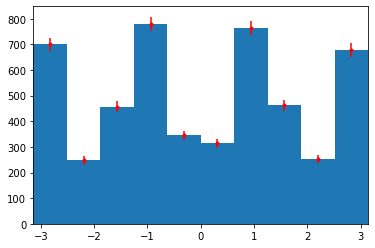

In [9]:
plot_dihedrals(dihedrals_new)

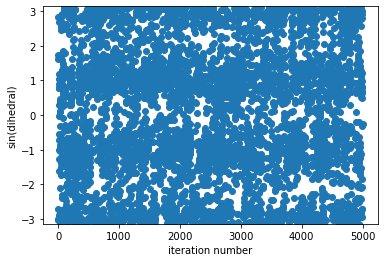

In [10]:
uncorrelated_new = plot_time_series(dihedrals_new, n_iter)


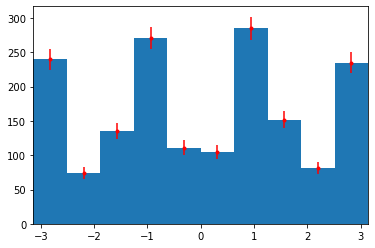

In [11]:
plot_dihedrals_uncorrelated(dihedrals_new, uncorrelated_new)

### Lambda = 0, old (THR)

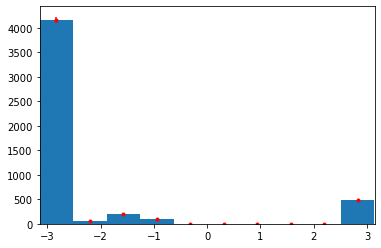

In [12]:
plot_dihedrals(dihedrals_old)

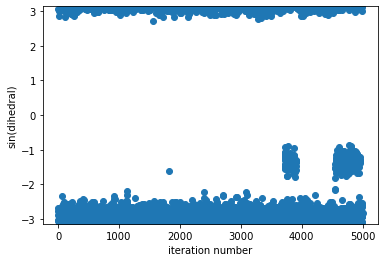

In [13]:
uncorrelated_old = plot_time_series(dihedrals_old, n_iter)

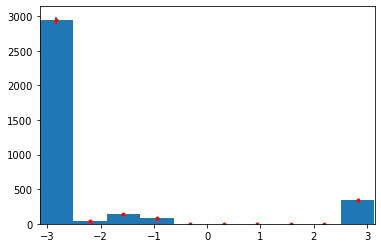

In [14]:
plot_dihedrals_uncorrelated(dihedrals_old, uncorrelated_old)

### Lambda = 1, new (ALA)

In [15]:
i = 7
endstate = 1
length = '5ns'
out_dir = f"/data/chodera/zhangi/perses_benchmark/neq/10/{i}/"

In [16]:
dihedrals_new, dihedrals_old, n_iter = get_dihedrals(i, endstate, length, out_dir, htf_1, [13, 10, 8, 6], [18, 10, 8, 6])

100%|██████████| 5001/5001 [00:44<00:00, 113.37it/s]


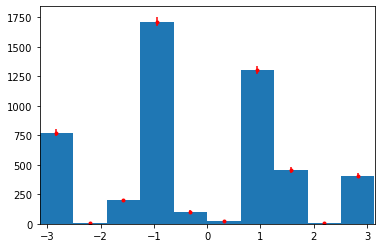

In [17]:
plot_dihedrals(dihedrals_new)

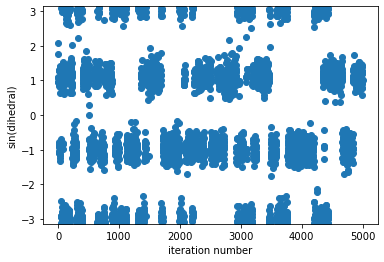

In [18]:
uncorrelated_new = plot_time_series(dihedrals_new, n_iter)


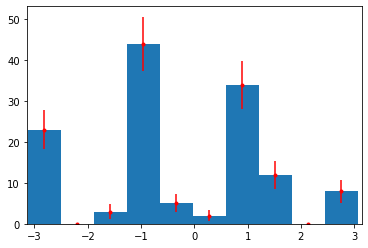

In [19]:
plot_dihedrals_uncorrelated(dihedrals_new, uncorrelated_new)

### Lambda = 1, old (THR)

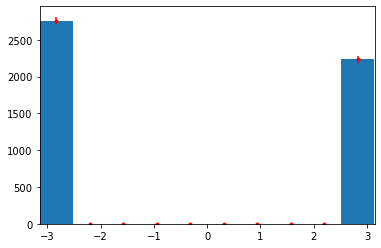

In [20]:
plot_dihedrals(dihedrals_old)

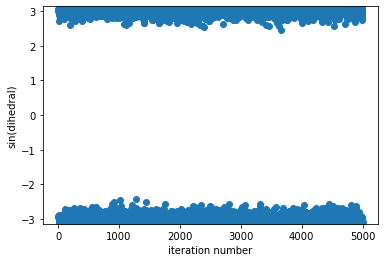

In [21]:
uncorrelated_old = plot_time_series(dihedrals_old, n_iter)

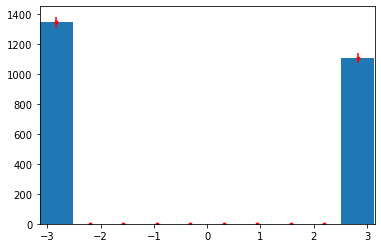

In [22]:
plot_dihedrals_uncorrelated(dihedrals_old, uncorrelated_old)

### ALA->THR

In [23]:
# Generate htf for capped ALA->THR in vacuum
atp, sys_gen = generate_atp()

# At alanine endstate
htf_0 = generate_dipeptide_top_pos_sys(atp.topology, 
                                         new_res = 'THR', 
                                         system = atp.system, 
                                         positions = atp.positions,
                                         system_generator = sys_gen, 
                                         conduct_htf_prop=True,
                                         repartitioned=True, endstate=0, validate_endstate_energy=False)

INFO:proposal_generator:	Conducting polymer point mutation proposal...
INFO:proposal_generator:Using matching_criterion to chose best atom map
INFO:proposal_generator:Scaffold has symmetry of 0
INFO:proposal_generator:len [{9: 7}, {10: 7}, {11: 7}, {12: 7}, {13: 7}, {9: 8}, {10: 8}, {11: 8}, {12: 8}, {13: 8}, {9: 9}, {10: 9}, {11: 9}, {12: 9}, {13: 9}]
INFO:proposal_generator:{9: 7}
INFO:proposal_generator:{10: 7}
INFO:proposal_generator:{11: 7}
INFO:proposal_generator:{12: 7}
INFO:proposal_generator:{13: 7}
INFO:proposal_generator:{9: 8}
INFO:proposal_generator:{10: 8}
INFO:proposal_generator:{11: 8}
INFO:proposal_generator:{12: 8}
INFO:proposal_generator:{13: 8}
INFO:proposal_generator:{9: 9}
INFO:proposal_generator:{10: 9}
INFO:proposal_generator:{11: 9}
INFO:proposal_generator:{12: 9}
INFO:proposal_generator:{13: 9}
INFO:proposal_generator:Returning map that best satisfies matching_criterion
INFO:proposal_generator:Finding best map using matching_criterion name
INFO:proposal_genera

making topology proposal
generating geometry engine
making geometry proposal from ALA to THR


INFO:geometry:neglected angle terms include []
INFO:geometry:log probability choice of torsions and atom order: -13.659277711932692
INFO:geometry:creating platform, integrators, and contexts; setting growth parameter


conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context new positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 8 new atoms
INFO:geometry:	reduced angle potential = 0.14460630482116224.
INFO:geometry:	reduced angle potential = 0.11214856469448466.
INFO:geometry:	reduced angle potential = 0.08971831123272725.
INFO:geometry:	reduced angle potential = 0.06509725269329046.
INFO:geometry:	reduced angle potential = 0.7841783786680059.
INFO:geometry:	reduced angle potential = 0.762927894843697.
INFO:geometry:	reduced angle potential = 0.02413874031034667.
INFO:geometry:	reduced angle potential = 1.5009369467134748.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 11 bond forces in the no-nonbonded final system
INFO:geometry:	there are 43 angle fo

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 9.116470338224556


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: -54.755366566211826
INFO:geometry:final reduced energy -45.63889690333653
INFO:geometry:sum of energies: -45.638896227987274
INFO:geometry:magnitude of difference in the energies: 6.753492627353808e-07
INFO:geometry:Final logp_proposal: 46.915641965428094


added energy components: [('CustomBondForce', 1.0362708555001898), ('CustomAngleForce', 5.888678057392933), ('CustomTorsionForce', 19.425902297339114), ('CustomBondForce', -81.10621777644404)]


INFO:geometry:logp_reverse: performing reverse proposal
INFO:geometry:logp_reverse: unique new atoms detected; proceeding to _logp_propose...
INFO:geometry:Conducting forward proposal...
INFO:geometry:Computing proposal order with NetworkX...
INFO:geometry:number of atoms to be placed: 4
INFO:geometry:Atom index proposal order is [10, 12, 11, 13]
INFO:geometry:omitted_bonds: []
INFO:geometry:direction of proposal is reverse; creating atoms_with_positions from old system/topology
INFO:geometry:creating growth system...
INFO:geometry:	creating bond force...
INFO:geometry:	there are 9 bonds in reference force.
INFO:geometry:	creating angle force...
INFO:geometry:	there are 36 angles in reference force.
INFO:geometry:	creating torsion force...
INFO:geometry:	creating extra torsions force...
INFO:geometry:	there are 42 torsions in reference force.
INFO:geometry:	creating nonbonded force...
INFO:geometry:		grabbing reference nonbonded method, cutoff, switching function, switching distance...

conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context old positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 4 new atoms
INFO:geometry:	reduced angle potential = 0.08012155678424232.
INFO:geometry:	reduced angle potential = 3.205828647416432e-13.
INFO:geometry:	reduced angle potential = 1.2915573155343707e-10.
INFO:geometry:	reduced angle potential = 7.390951941228323e-11.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 9 bond forces in the no-nonbonded final system
INFO:geometry:	there are 36 angle forces in the no-nonbonded final system
INFO:geometry:	there are 42 torsion forces in the no-nonbonded final system
INFO:geometry:reverse final system defined with 0 neglected angles.


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 9.116470338224556


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: 20.67296217359934
INFO:geometry:final reduced energy 29.789432654951565
INFO:geometry:sum of energies: 29.789432511823897
INFO:geometry:magnitude of difference in the energies: 1.431276679397797e-07
INFO:geometry:Final logp_proposal: 23.528099088000474


added energy components: [('CustomBondForce', 0.000520203310858755), ('CustomAngleForce', 0.4511192410252491), ('CustomTorsionForce', 7.250454736370486), ('CustomBondForce', 12.970867992892748)]


INFO:relative:Old system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:New system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:No unknown forces.
INFO:relative:Nonbonded method to be used (i.e. from old system): 0
INFO:relative:Adding and mapping old atoms to hybrid system...
INFO:relative:Adding and mapping new atoms to hybrid system...
INFO:relative:No MonteCarloBarostat added.
INFO:relative:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=2.0, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=2.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=2.0), unit=nanometer)]
INFO:relative:Determined atom classes.
INFO:relative:Generating old system exceptions dict...
INFO:relative:Generating new system exceptions dict...
INFO:relative:Handling constraints...
INFO:relative:Handling virtual sites...
INFO:

In [24]:
# At threonine endstate
htf_1 = generate_dipeptide_top_pos_sys(atp.topology, 
                                         new_res = 'THR', 
                                         system = atp.system, 
                                         positions = atp.positions,
                                         system_generator = sys_gen, 
                                         conduct_htf_prop=True,
                                         repartitioned=True, endstate=1, validate_endstate_energy=False)

INFO:proposal_generator:	Conducting polymer point mutation proposal...
INFO:proposal_generator:Using matching_criterion to chose best atom map
INFO:proposal_generator:Scaffold has symmetry of 0
INFO:proposal_generator:len [{9: 7}, {10: 7}, {11: 7}, {12: 7}, {13: 7}, {9: 8}, {10: 8}, {11: 8}, {12: 8}, {13: 8}, {9: 9}, {10: 9}, {11: 9}, {12: 9}, {13: 9}]
INFO:proposal_generator:{9: 7}
INFO:proposal_generator:{10: 7}
INFO:proposal_generator:{11: 7}
INFO:proposal_generator:{12: 7}
INFO:proposal_generator:{13: 7}
INFO:proposal_generator:{9: 8}
INFO:proposal_generator:{10: 8}
INFO:proposal_generator:{11: 8}
INFO:proposal_generator:{12: 8}
INFO:proposal_generator:{13: 8}
INFO:proposal_generator:{9: 9}
INFO:proposal_generator:{10: 9}
INFO:proposal_generator:{11: 9}
INFO:proposal_generator:{12: 9}
INFO:proposal_generator:{13: 9}
INFO:proposal_generator:Returning map that best satisfies matching_criterion
INFO:proposal_generator:Finding best map using matching_criterion name
INFO:proposal_genera

making topology proposal
generating geometry engine
making geometry proposal from ALA to THR


INFO:geometry:Neglected angle terms : []
INFO:geometry:omitted_growth_terms: {'bonds': [], 'angles': [], 'torsions': [], '1,4s': []}
INFO:geometry:extra torsions: {0: (14, 10, 8, 18, [1, Quantity(value=1.0655064807976995, unit=radian), Quantity(value=120.0, unit=kilocalorie/mole), 3])}
INFO:geometry:neglected angle terms include []
INFO:geometry:log probability choice of torsions and atom order: -13.659277711932692
INFO:geometry:creating platform, integrators, and contexts; setting growth parameter


conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context new positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 8 new atoms
INFO:geometry:	reduced angle potential = 0.13792576188956898.
INFO:geometry:	reduced angle potential = 1.4675977400423712.
INFO:geometry:	reduced angle potential = 0.02631238379414329.
INFO:geometry:	reduced angle potential = 0.003982537111496854.
INFO:geometry:	reduced angle potential = 0.30993782121136343.
INFO:geometry:	reduced angle potential = 0.38490748685333576.
INFO:geometry:	reduced angle potential = 0.061359159614379086.
INFO:geometry:	reduced angle potential = 2.7765906013504043.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 11 bond forces in the no-nonbonded final system
INFO:geometry:	there are 43 angl

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 9.116470338224556


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: -38.507310803410554
INFO:geometry:final reduced energy -29.390840967657603
INFO:geometry:sum of energies: -29.390840465186
INFO:geometry:magnitude of difference in the energies: 5.024716003276808e-07
INFO:geometry:Final logp_proposal: 41.26890477610168


added energy components: [('CustomBondForce', 1.066733724920832), ('CustomAngleForce', 17.65875680456385), ('CustomTorsionForce', 20.012830923623397), ('CustomBondForce', -77.2456322565186)]


INFO:geometry:logp_reverse: performing reverse proposal
INFO:geometry:logp_reverse: unique new atoms detected; proceeding to _logp_propose...
INFO:geometry:Conducting forward proposal...
INFO:geometry:Computing proposal order with NetworkX...
INFO:geometry:number of atoms to be placed: 4
INFO:geometry:Atom index proposal order is [10, 13, 12, 11]
INFO:geometry:omitted_bonds: []
INFO:geometry:direction of proposal is reverse; creating atoms_with_positions from old system/topology
INFO:geometry:creating growth system...
INFO:geometry:	creating bond force...
INFO:geometry:	there are 9 bonds in reference force.
INFO:geometry:	creating angle force...
INFO:geometry:	there are 36 angles in reference force.
INFO:geometry:	creating torsion force...
INFO:geometry:	creating extra torsions force...
INFO:geometry:	there are 42 torsions in reference force.
INFO:geometry:	creating nonbonded force...
INFO:geometry:		grabbing reference nonbonded method, cutoff, switching function, switching distance...

conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context old positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 4 new atoms
INFO:geometry:	reduced angle potential = 0.08012155678424232.
INFO:geometry:	reduced angle potential = 7.390951941228323e-11.
INFO:geometry:	reduced angle potential = 3.205828647416432e-13.
INFO:geometry:	reduced angle potential = 1.2915573155343707e-10.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 9 bond forces in the no-nonbonded final system
INFO:geometry:	there are 36 angle forces in the no-nonbonded final system
INFO:geometry:	there are 42 torsion forces in the no-nonbonded final system
INFO:geometry:reverse final system defined with 0 neglected angles.


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 9.116470338224556


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: 20.67296217359934
INFO:geometry:final reduced energy 29.789432654951565
INFO:geometry:sum of energies: 29.789432511823897
INFO:geometry:magnitude of difference in the energies: 1.431276679397797e-07
INFO:geometry:Final logp_proposal: 26.134474971846238


added energy components: [('CustomBondForce', 0.000520203310858755), ('CustomAngleForce', 0.4511192410252491), ('CustomTorsionForce', 7.250454736370486), ('CustomBondForce', 12.970867992892748)]


INFO:relative:Old system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:New system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:No unknown forces.
INFO:relative:Nonbonded method to be used (i.e. from old system): 0
INFO:relative:Adding and mapping old atoms to hybrid system...
INFO:relative:Adding and mapping new atoms to hybrid system...
INFO:relative:No MonteCarloBarostat added.
INFO:relative:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=2.0, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=2.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=2.0), unit=nanometer)]
INFO:relative:Determined atom classes.
INFO:relative:Generating old system exceptions dict...
INFO:relative:Generating new system exceptions dict...
INFO:relative:Handling constraints...
INFO:relative:Handling virtual sites...
INFO:

In [25]:
for atom in htf_0._topology_proposal.old_topology.atoms():
    print(atom)

<Atom 0 (H1) of chain 0 residue 0 (ACE)>
<Atom 1 (CH3) of chain 0 residue 0 (ACE)>
<Atom 2 (H2) of chain 0 residue 0 (ACE)>
<Atom 3 (H3) of chain 0 residue 0 (ACE)>
<Atom 4 (C) of chain 0 residue 0 (ACE)>
<Atom 5 (O) of chain 0 residue 0 (ACE)>
<Atom 6 (N) of chain 0 residue 1 (ALA)>
<Atom 7 (H) of chain 0 residue 1 (ALA)>
<Atom 8 (CA) of chain 0 residue 1 (ALA)>
<Atom 9 (HA) of chain 0 residue 1 (ALA)>
<Atom 10 (CB) of chain 0 residue 1 (ALA)>
<Atom 11 (HB1) of chain 0 residue 1 (ALA)>
<Atom 12 (HB2) of chain 0 residue 1 (ALA)>
<Atom 13 (HB3) of chain 0 residue 1 (ALA)>
<Atom 14 (C) of chain 0 residue 1 (ALA)>
<Atom 15 (O) of chain 0 residue 1 (ALA)>
<Atom 16 (N) of chain 0 residue 2 (NME)>
<Atom 17 (H) of chain 0 residue 2 (NME)>
<Atom 18 (C) of chain 0 residue 2 (NME)>
<Atom 19 (H1) of chain 0 residue 2 (NME)>
<Atom 20 (H2) of chain 0 residue 2 (NME)>
<Atom 21 (H3) of chain 0 residue 2 (NME)>


In [26]:
for atom in htf_0._topology_proposal.new_topology.atoms():
    print(atom)

<Atom 0 (H1) of chain 0 residue 0 (ACE)>
<Atom 1 (CH3) of chain 0 residue 0 (ACE)>
<Atom 2 (H2) of chain 0 residue 0 (ACE)>
<Atom 3 (H3) of chain 0 residue 0 (ACE)>
<Atom 4 (C) of chain 0 residue 0 (ACE)>
<Atom 5 (O) of chain 0 residue 0 (ACE)>
<Atom 6 (N) of chain 0 residue 1 (THR)>
<Atom 7 (H) of chain 0 residue 1 (THR)>
<Atom 8 (CA) of chain 0 residue 1 (THR)>
<Atom 9 (HA) of chain 0 residue 1 (THR)>
<Atom 10 (CB) of chain 0 residue 1 (THR)>
<Atom 11 (C) of chain 0 residue 1 (THR)>
<Atom 12 (O) of chain 0 residue 1 (THR)>
<Atom 13 (HB) of chain 0 residue 1 (THR)>
<Atom 14 (CG2) of chain 0 residue 1 (THR)>
<Atom 15 (HG21) of chain 0 residue 1 (THR)>
<Atom 16 (HG22) of chain 0 residue 1 (THR)>
<Atom 17 (HG23) of chain 0 residue 1 (THR)>
<Atom 18 (OG1) of chain 0 residue 1 (THR)>
<Atom 19 (HG1) of chain 0 residue 1 (THR)>
<Atom 20 (N) of chain 0 residue 2 (NME)>
<Atom 21 (H) of chain 0 residue 2 (NME)>
<Atom 22 (C) of chain 0 residue 2 (NME)>
<Atom 23 (H1) of chain 0 residue 2 (NME)>
<

In [27]:
for atom in htf_1._topology_proposal.old_topology.atoms():
    print(atom)

<Atom 0 (H1) of chain 0 residue 0 (ACE)>
<Atom 1 (CH3) of chain 0 residue 0 (ACE)>
<Atom 2 (H2) of chain 0 residue 0 (ACE)>
<Atom 3 (H3) of chain 0 residue 0 (ACE)>
<Atom 4 (C) of chain 0 residue 0 (ACE)>
<Atom 5 (O) of chain 0 residue 0 (ACE)>
<Atom 6 (N) of chain 0 residue 1 (ALA)>
<Atom 7 (H) of chain 0 residue 1 (ALA)>
<Atom 8 (CA) of chain 0 residue 1 (ALA)>
<Atom 9 (HA) of chain 0 residue 1 (ALA)>
<Atom 10 (CB) of chain 0 residue 1 (ALA)>
<Atom 11 (HB1) of chain 0 residue 1 (ALA)>
<Atom 12 (HB2) of chain 0 residue 1 (ALA)>
<Atom 13 (HB3) of chain 0 residue 1 (ALA)>
<Atom 14 (C) of chain 0 residue 1 (ALA)>
<Atom 15 (O) of chain 0 residue 1 (ALA)>
<Atom 16 (N) of chain 0 residue 2 (NME)>
<Atom 17 (H) of chain 0 residue 2 (NME)>
<Atom 18 (C) of chain 0 residue 2 (NME)>
<Atom 19 (H1) of chain 0 residue 2 (NME)>
<Atom 20 (H2) of chain 0 residue 2 (NME)>
<Atom 21 (H3) of chain 0 residue 2 (NME)>


In [28]:
for atom in htf_1._topology_proposal.new_topology.atoms():
    print(atom)

<Atom 0 (H1) of chain 0 residue 0 (ACE)>
<Atom 1 (CH3) of chain 0 residue 0 (ACE)>
<Atom 2 (H2) of chain 0 residue 0 (ACE)>
<Atom 3 (H3) of chain 0 residue 0 (ACE)>
<Atom 4 (C) of chain 0 residue 0 (ACE)>
<Atom 5 (O) of chain 0 residue 0 (ACE)>
<Atom 6 (N) of chain 0 residue 1 (THR)>
<Atom 7 (H) of chain 0 residue 1 (THR)>
<Atom 8 (CA) of chain 0 residue 1 (THR)>
<Atom 9 (HA) of chain 0 residue 1 (THR)>
<Atom 10 (CB) of chain 0 residue 1 (THR)>
<Atom 11 (C) of chain 0 residue 1 (THR)>
<Atom 12 (O) of chain 0 residue 1 (THR)>
<Atom 13 (HB) of chain 0 residue 1 (THR)>
<Atom 14 (CG2) of chain 0 residue 1 (THR)>
<Atom 15 (HG21) of chain 0 residue 1 (THR)>
<Atom 16 (HG22) of chain 0 residue 1 (THR)>
<Atom 17 (HG23) of chain 0 residue 1 (THR)>
<Atom 18 (OG1) of chain 0 residue 1 (THR)>
<Atom 19 (HG1) of chain 0 residue 1 (THR)>
<Atom 20 (N) of chain 0 residue 2 (NME)>
<Atom 21 (H) of chain 0 residue 2 (NME)>
<Atom 22 (C) of chain 0 residue 2 (NME)>
<Atom 23 (H1) of chain 0 residue 2 (NME)>
<

### Lambda = 0, new (THR)

In [29]:
i = 6
endstate = 0
length = '5ns'
out_dir = f"/data/chodera/zhangi/perses_benchmark/neq/10/{i}/"

In [30]:
dihedrals_new, dihedrals_old, n_iter = get_dihedrals(i, endstate, length, out_dir, htf_0, [18, 10, 8, 6], [11, 10, 8, 6])

100%|██████████| 5001/5001 [00:44<00:00, 111.76it/s]


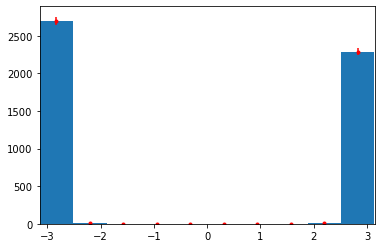

In [31]:
plot_dihedrals(dihedrals_new)

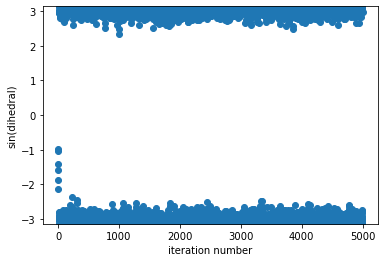

In [32]:
uncorrelated_new = plot_time_series(dihedrals_new, n_iter)


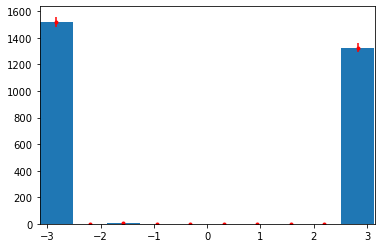

In [33]:
plot_dihedrals_uncorrelated(dihedrals_new, uncorrelated_new)

### Lambda = 0, old (ALA)

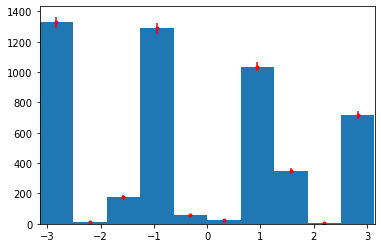

In [34]:
plot_dihedrals(dihedrals_old)

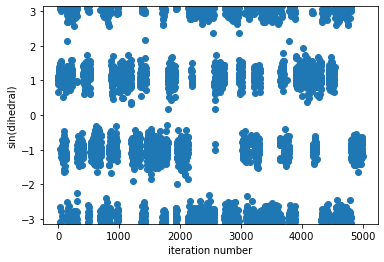

In [35]:
uncorrelated_old = plot_time_series(dihedrals_old, n_iter)

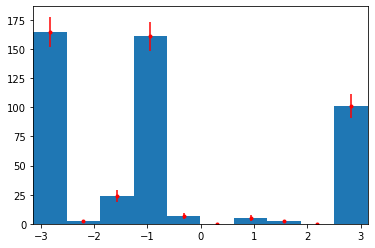

In [36]:
plot_dihedrals_uncorrelated(dihedrals_old, uncorrelated_old)

### Lambda = 1, new (THR)

In [37]:
i = 6
endstate = 1
length = '5ns'
out_dir = f"/data/chodera/zhangi/perses_benchmark/neq/10/{i}/"

In [38]:
dihedrals_new, dihedrals_old, n_iter = get_dihedrals(i, endstate, length, out_dir, htf_1, [18, 10, 8, 6], [11, 10, 8, 6])

100%|██████████| 5001/5001 [00:44<00:00, 113.17it/s]


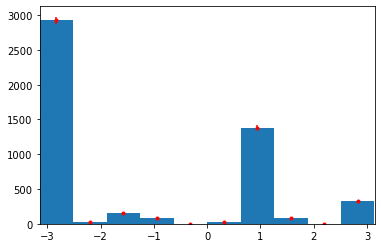

In [39]:
plot_dihedrals(dihedrals_new)

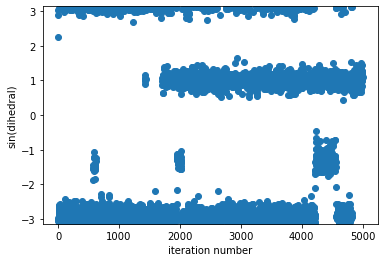

In [40]:
uncorrelated_new = plot_time_series(dihedrals_new, n_iter)


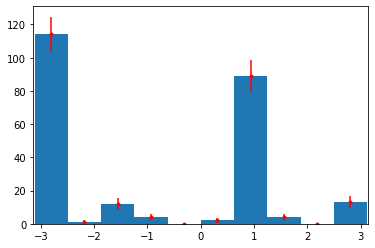

In [41]:
plot_dihedrals_uncorrelated(dihedrals_new, uncorrelated_new)

### Lambda = 1, old (ALA)

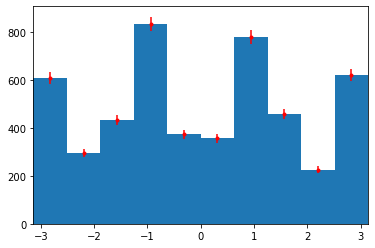

In [42]:
plot_dihedrals(dihedrals_old)

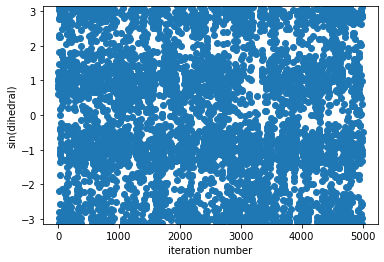

In [43]:
uncorrelated_old = plot_time_series(dihedrals_old, n_iter)

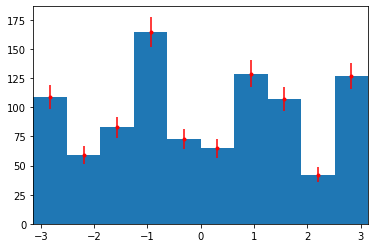

In [44]:
plot_dihedrals_uncorrelated(dihedrals_old, uncorrelated_old)